In [1]:
import pandas as pd

# Read the CSV file
file_path = '../preped.csv'
df = pd.read_csv(file_path)

In [2]:
print(df.columns)

Index(['Title', 'Is Series', 'Hidden Gem Score', 'Runtime', 'IMDb Score',
       'Rotten Tomatoes Score', 'Metacritic Score', 'Awards Received',
       'Awards Nominated For', 'Boxoffice', 'Release Date', 'IMDb Votes',
       'Minimum Age', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance',
       'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')


In [3]:
df['Release Date']

0       1614816000
1       1614816000
2       1614729600
3       1614729600
4       1614729600
           ...    
2504    1428969600
2505    1428969600
2506    1428969600
2507    1428969600
2508    1428969600
Name: Release Date, Length: 2509, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the feature columns and target column
feature_columns = ['Is Series', 'Hidden Gem Score', 'Runtime', 'IMDb Score', 'Rotten Tomatoes Score', 'Metacritic Score', 'Awards Received', 'Awards Nominated For', 'Boxoffice', 'Release Date', 'IMDb Votes', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']
target_column = 'Minimum Age'

# Separate the features and target variable
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error: 2.6508964143426295
Mean Squared Error: 15.87341294820717
R^2 Score: 0.42448857014852204


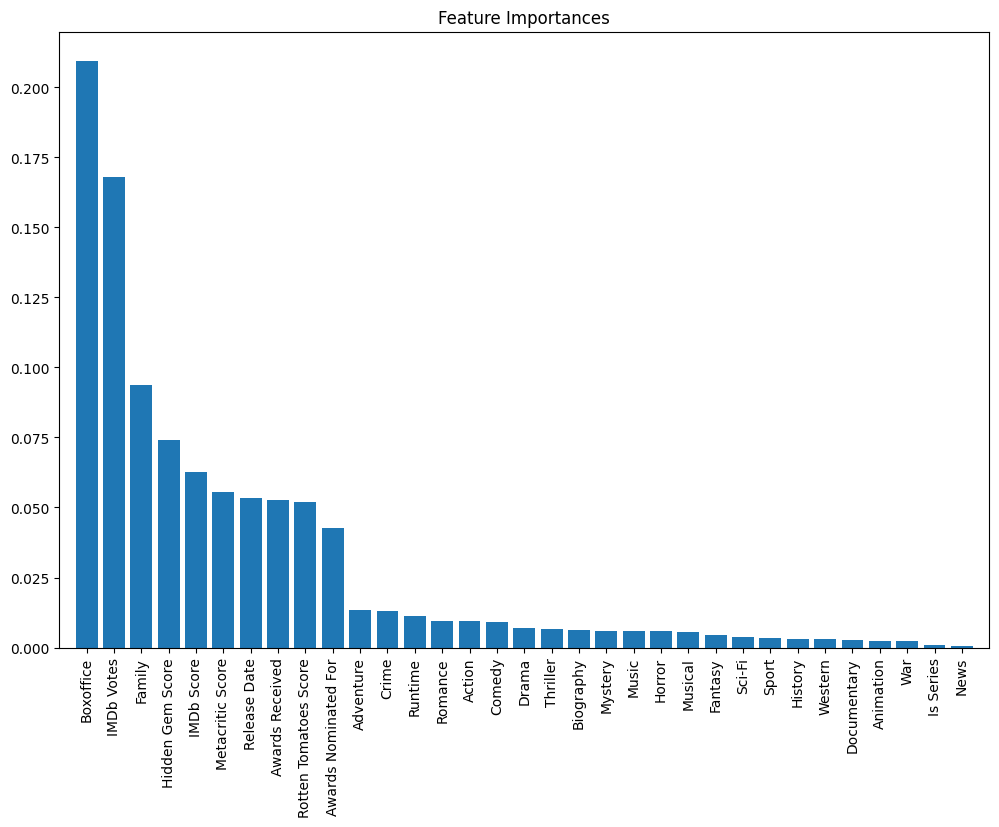

In [5]:
import numpy as np

import matplotlib.pyplot as plt

# Get feature importances from the model
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_columns[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [130]:
# Convert 'Release Date' from Unix timestamp to datetime
time = pd.to_datetime(df['Release Date'], unit='s')

# Extract 'Release Year' and 'Release Month'
df['Release Year'] = time.dt.year
df['Release Month'] = time.dt.month


df[['Release Year', 'Release Month']]

,Release Year,Release Month
0,2021,3
1,2021,3
2,2021,3
3,2021,3
4,2021,3
5,2021,3
6,2021,3
7,2021,2
8,2021,2
9,2021,2


In [131]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the feature columns and target column
feature_columns = ['Is Series', 'Hidden Gem Score', 'Release Year', 'Release Month', 'Runtime', 'IMDb Score', 'Rotten Tomatoes Score', 'Metacritic Score', 'Awards Received', 'Awards Nominated For', 'Boxoffice', 'Release Date', 'IMDb Votes', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']
target_column = 'Minimum Age'

# Separate the features and target variable
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error: 2.685258964143426
Mean Squared Error: 16.079097609561753
R^2 Score: 0.4170312026661205


Without Month/Year\
Mean Absolute Error: 2.6508964143426295\
Mean Squared Error: 15.87341294820717\
R^2 Score: 0.42448857014852204\

With Month/Year\
Mean Absolute Error: 2.685258964143426\
Mean Squared Error: 16.079097609561753\
R^2 Score: 0.4170312026661205

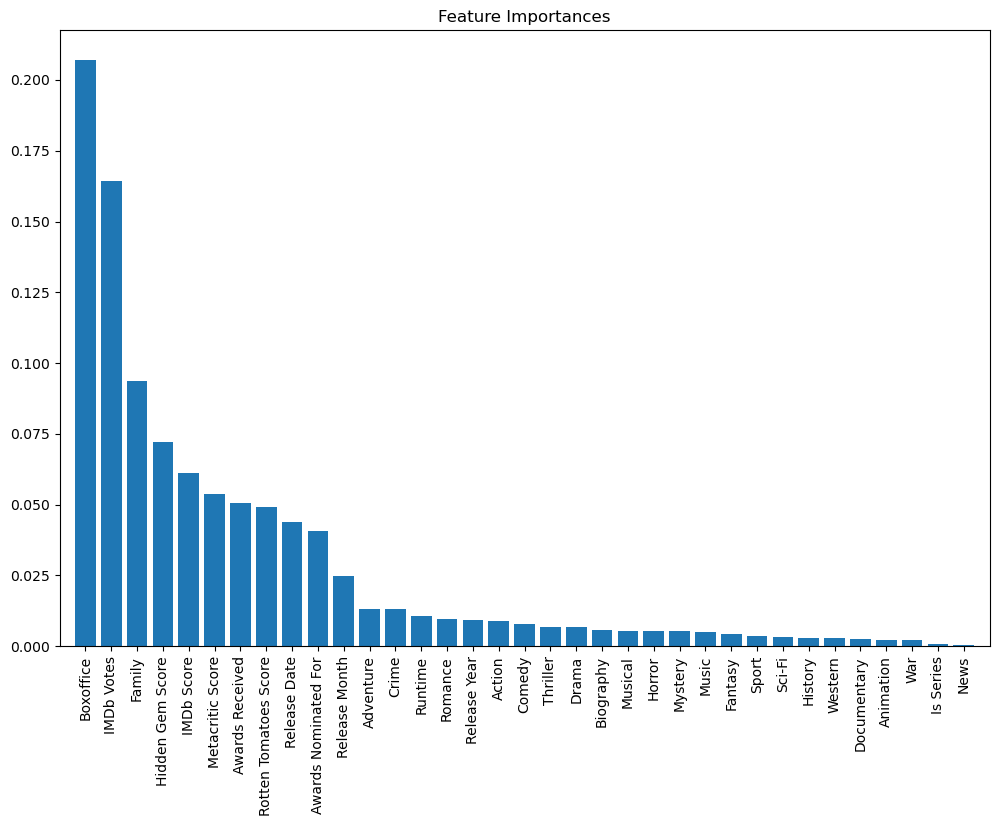

In [132]:
import numpy as np

import matplotlib.pyplot as plt

# Get feature importances from the model
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_columns[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Define the feature columns and target column
feature_columns = ['Is Series', 'Hidden Gem Score', 'Release Year', 'Release Month', 'Runtime', 'IMDb Score', 'Rotten Tomatoes Score', 'Metacritic Score', 'Awards Received', 'Awards Nominated For', 'Boxoffice', 'Release Date', 'IMDb Votes', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']
target_column = 'Minimum Age'

# Separate the features and target variable
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the base Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Perform hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],           # Number of trees
    'max_depth': [10, 20, 30, None],           # Maximum depth of trees
    'min_samples_split': [2, 5, 10],           # Minimum samples required to split
    'min_samples_leaf': [1, 2, 4],             # Minimum samples per leaf node
    'max_features': ['sqrt', 'log2', None],    # Number of features to consider at each split
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Mean Absolute Error: 2.7117058956272846
Mean Squared Error: 15.471498342231293
R^2 Score: 0.4390605119431501


Normal with all\
Mean Absolute Error: 2.6771188598434255\
Mean squared Error: 15.796815884320345\
R^2 score: 0.4272656972795156

Without Release Year and Release Month\
Mean Absolute Error: 2.7117058956272846\
Mean Squared Error: 15.471498342231293\
R^2 Score: 0.4390605119431501

Without boxoffice
Mean Absolute Error: 2.880205843293493\
Mean Squared Error: 16.890488999557324\
R^2 Score: 0.38761314238197264

Without Genres
Mean Absolute Error: 3.13993962642096\
Mean Squared Error: 17.806074707839812\
R^2 Score: 0.35441738027053915

In [134]:


# Detailed results for all combinations
cv_results = grid_search.cv_results_

# Highlight the best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation R^2 Score: {best_score:.3f}")



Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Cross-Validation R^2 Score: 0.313


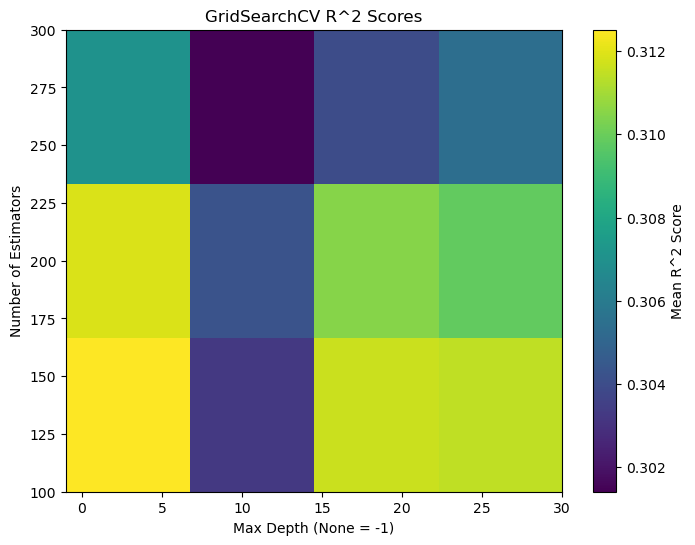

In [135]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for plotting
param_grid_combinations = [
    (cv_results['param_n_estimators'][i],
     cv_results['param_max_depth'][i] if cv_results['param_max_depth'][i] is not None else -1,  # Handle None
     cv_results['mean_test_score'][i])
    for i in range(len(cv_results['mean_test_score']))
]

# Convert to numpy array for easier manipulation
param_array = np.array(param_grid_combinations, dtype=object)

# Reshape data for a specific hyperparameter relationship
# Example: n_estimators vs. max_depth
estimators = np.unique(param_array[:, 0])  # Unique n_estimators values
depths = np.unique(param_array[:, 1])      # Unique max_depth values
scores_matrix = np.zeros((len(estimators), len(depths)))

# Fill the scores matrix
for i, est in enumerate(estimators):
    for j, dep in enumerate(depths):
        score = param_array[(param_array[:, 0] == est) & (param_array[:, 1] == dep), 2]
        scores_matrix[i, j] = score[0] if len(score) > 0 else np.nan

# Heatmap of R^2 scores
plt.figure(figsize=(8, 6))
plt.imshow(scores_matrix, cmap='viridis', aspect='auto', extent=[min(depths), max(depths), min(estimators), max(estimators)])
plt.colorbar(label='Mean R^2 Score')
plt.xlabel('Max Depth (None = -1)')
plt.ylabel('Number of Estimators')
plt.title('GridSearchCV R^2 Scores')
plt.show()


In [136]:
# Highlight the best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation R^2 Score: {best_score:.3f}")


Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Cross-Validation R^2 Score: 0.313


In [137]:
# Predictions
y_pred = best_model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Absolute Error: 2.880205843293493
Mean Squared Error: 16.890488999557324
R^2 Score: 0.38761314238197264


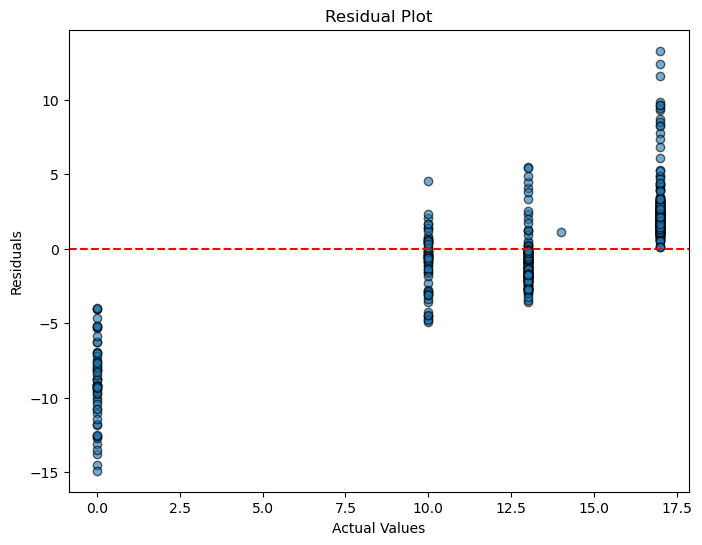

In [138]:
# Residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.6, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


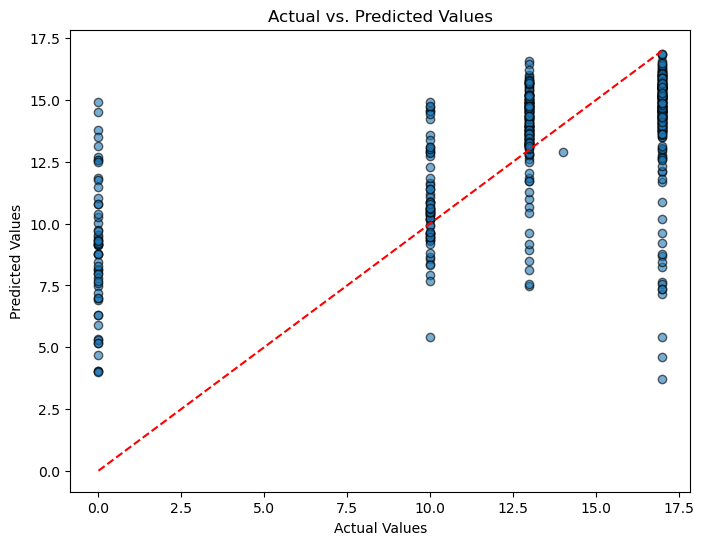

In [139]:
# Plot actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()
